In [1]:
import numpy as np
import sys
#np.set_printoptions(precision=5, linewidth=200, suppress=True)
import psi4
from helper_PFCI import PFHamiltonianGenerator
from helper_PFCI import Determinant
from helper_cqed_rhf import cqed_rhf
np.set_printoptions(threshold=sys.maxsize)
psi4.core.set_output_file('output.dat', False)

In [2]:
# options for mgf
mol_str = """
Li
H 1 1.5
symmetry c1
"""

options_dict = {
    "basis": "sto-3g",
    "scf_type": "pk",
    "e_convergence": 1e-10,
    "d_convergence": 1e-10,
    "save_jk" : True
}


psi4.set_options(options_dict)
mol = psi4.geometry(mol_str)


In [4]:
mol_str = """
Li
H 1 1.5
symmetry c1
"""

options_dict = {
    "basis": "sto-3g",
    "scf_type": "pk",
    "e_convergence": 1e-10,
    "d_convergence": 1e-10,
}

pcqed_dict = {
    'omega_value' : 0.0,
    'lambda_vector' : np.array([0, 0, 0]),
    'ci_level' : 'fci',
    'full_diagonalization' : True,
    'number_of_photons' : 0
}

scqed_dict_np = {
    'omega_value' : 0.12086,
    'lambda_vector' : np.array([0, 0, 0.08]),
    'ci_level' : 'fci',
    'full_diagonalization' : True,
    'number_of_photons' : 0
}

scqed_dict = {
    'omega_value' : 0.12086,
    'lambda_vector' : np.array([0, 0, 0.08]),
    'ci_level' : 'fci',
    'full_diagonalization' : True,
    'number_of_photons' : 6
}


mol = psi4.geometry(mol_str)

psi4.set_options(options_dict)

no_cavity = PFHamiltonianGenerator(
    mol_str,
    options_dict,
    pcqed_dict
)

cavity_zp = PFHamiltonianGenerator(
    mol_str,
    options_dict,
    scqed_dict_np
)




Start SCF iterations:

Canonical RHF One-electron energy = -12.5626302721254959
CQED-RHF One-electron energy      = -12.5626302721254959
Nuclear repulsion energy          = 1.0583544213400000
Dipole energy                     = 0.0000000000000000
SCF Iteration   1: Energy = -7.8633576215383263   dE = -7.86336E+00   dRMS = 3.54673E-13
SCF Iteration   2: Energy = -7.8633576215383370   dE = -1.06581E-14   dRMS = 7.99578E-14
Total time for SCF iterations: 0.000 seconds 

QED-RHF   energy: -7.86335762 hartree
Psi4  SCF energy: -7.86335762 hartree
 Completed QED-RHF in 0.2174057960510254 seconds
 Completed 1HSO Build in 5.817413330078125e-05 seconds
 Completed ERI Build in 0.0011868476867675781 seconds 
 Completed 2D build in 8.797645568847656e-05 seconds
 Completed 1G build in 1.5020370483398438e-05 seconds
 Completed the Dipole Matrix Build in 3.886222839355469e-05 seconds
 Completed determinant list in 0.00045418739318847656 seconds 
 Completed constant offset matrix in 0.000103950500488

In [5]:
print(cavity_zp.Delta[0,0])
lv = np.copy(cavity_zp.lambda_vector)

M00 = np.copy(cavity_zp.MUMU[0,0,:])
D00 =  lv[0] * lv[0] * M00[0] + lv[1] * lv[1] * M00[1]  + lv[2] * lv[2] * M00[2]
D00 += lv[0] * lv[1] * M00[3] + lv[0] * lv[2] * M00[4]  + lv[1] * lv[2] * M00[5]

print(D00)

Q_PF = np.copy(cavity_zp.Q1spin)
Q_PF_t  = lv[0] * lv[0] * cavity_zp.q_xx_spin + lv[1] * lv[1] * cavity_zp.q_yy_spin
Q_PF_t += lv[2] * lv[2] * cavity_zp.q_zz_spin + lv[0] * lv[1] * cavity_zp.q_xy_spin
Q_PF_t += lv[0] * lv[2] * cavity_zp.q_xz_spin + lv[1] * lv[2] * cavity_zp.q_yz_spin

print(Q_PF[0,0])
print(Q_PF_t[0,0])

0.04588605623952968
0.04588605623952968
0.0008876341757216512
0.0017752683514433022


In [6]:
print(cavity_zp.Delta[10,0])
Ns = len(cavity_zp.Delta[:,0])
lv = np.copy(cavity_zp.lambda_vector)
for i in range(Ns):
    for j in range(Ns):
        M00 = np.copy(cavity_zp.MUMU[i,j,:])
        D00 =  lv[0] * lv[0] * M00[0] + lv[1] * lv[1] * M00[1]  + lv[2] * lv[2] * M00[2]
        D00 += lv[0] * lv[1] * M00[3] + lv[0] * lv[2] * M00[4]  + lv[1] * lv[2] * M00[5]
        assert np.isclose(D00, cavity_zp.Delta[i,j])
        
#print(cavity_zp.MUMU[:2,:2,0])

-1.9522671759785467e-19


In [9]:
mol_tmpl = """
Li
H 1 **R**
symmetry c1
"""

mol_str = """
Li
H 1 1.5
symmetry c1
"""

N_R = 50
N_el = 50
r_array = np.linspace(1.4, 2.2, N_R)

E_array = np.zeros((N_R, N_el))
Mu_array = np.zeros((N_R, N_el, N_el, 3))
MuMu_array = np.zeros((N_R, N_el, N_el, 6))
# scqed results
sc_E_array = np.zeros((N_R, 10))
                      
psi4.set_options(options_dict)

r_idx = 0
for r in r_array:
    mol_str = mol_tmpl.replace("**R**", str(r))
    print(mol_str)
    mol = psi4.geometry(mol_str)
    scf_e, wfn = psi4.energy('SCF', return_wfn=True)
    fci_energy = psi4.energy('fci',ref_wfn=wfn)
    
    LiH = PFHamiltonianGenerator(mol_str,options_dict,pcqed_dict)
    assert np.isclose(fci_energy, LiH.CIeigs[0], 1e-7)
    # sort out states with dipole-allowed transition from ground state
    singlet_states = LiH.sort_dipole_allowed_states( N_el)
    E_array[r_idx, :] = LiH.CIeigs[singlet_states]
    Mu_array[r_idx, :, :, :] = LiH.compute_dipole_moments(singlet_states)
    MuMu_array[r_idx, :, :, :] = LiH.compute_MuMu_Matrix(singlet_states)
    
    # uncomment to try not sorting singlet states
    #E_array[r_idx, :] = LiH.CIeigs[all_states]
    #Mu_array[r_idx, :, :, :] = LiH.compute_dipole_moments(all_states)
    # scqed results
    cqed_res = PFHamiltonianGenerator(mol_str, options_dict, scqed_dict)
    sc_E_array[r_idx, :] = cqed_res.CIeigs[:10]
    r_idx += 1




Li
H 1 1.4
symmetry c1


Start SCF iterations:

Canonical RHF One-electron energy = -12.6946346236295895
CQED-RHF One-electron energy      = -12.6946346236295895
Nuclear repulsion energy          = 1.1339511657214287
Dipole energy                     = 0.0000000000000000
SCF Iteration   1: Energy = -7.8605386610570385   dE = -7.86054E+00   dRMS = 1.78770E-13
SCF Iteration   2: Energy = -7.8605386610570473   dE = -8.88178E-15   dRMS = 3.97284E-14
Total time for SCF iterations: 0.000 seconds 

QED-RHF   energy: -7.86053866 hartree
Psi4  SCF energy: -7.86053866 hartree
 Completed QED-RHF in 0.08772110939025879 seconds
 Completed 1HSO Build in 5.793571472167969e-05 seconds
 Completed ERI Build in 0.0012707710266113281 seconds 
 Completed 2D build in 9.512901306152344e-05 seconds
 Completed 1G build in 1.9073486328125e-05 seconds
 Completed the Dipole Matrix Build in 4.315376281738281e-05 seconds
 Completed determinant list in 0.0004611015319824219 seconds 
 Completed constant offset matri

 Completed 1HSO Build in 5.0067901611328125e-05 seconds
 Completed ERI Build in 0.0011701583862304688 seconds 
 Completed 2D build in 0.00015592575073242188 seconds
 Completed 1G build in 2.193450927734375e-05 seconds
 Completed the Dipole Matrix Build in 4.506111145019531e-05 seconds
 Completed determinant list in 0.00043201446533203125 seconds 
 Completed constant offset matrix in 5.507469177246094e-05 seconds
 Completed Hamiltonian build in 0.6945540904998779 seconds

Start SCF iterations:

Canonical RHF One-electron energy = -12.6287313839641975
CQED-RHF One-electron energy      = -12.5926169080410055
Nuclear repulsion energy          = 1.0956204220914088
Dipole energy                     = 0.0340535961359028
SCF Iteration   1: Energy = -7.8523900659345962   dE = -7.85239E+00   dRMS = 8.17876E-04
SCF Iteration   2: Energy = -7.8524254736263668   dE = -3.54077E-05   dRMS = 1.22470E-04
SCF Iteration   3: Energy = -7.8524270872567214   dE = -1.61363E-06   dRMS = 3.29672E-05
SCF Iterat

 Completed Hamiltonian build in 0.6984298229217529 seconds

Start SCF iterations:

Canonical RHF One-electron energy = -12.5652261719185372
CQED-RHF One-electron energy      = -12.5278656088086091
Nuclear repulsion energy          = 1.0597963210965946
Dipole energy                     = 0.0350894830448543
SCF Iteration   1: Energy = -7.8529192086886557   dE = -7.85292E+00   dRMS = 8.22651E-04
SCF Iteration   2: Energy = -7.8529589653866463   dE = -3.97567E-05   dRMS = 1.42482E-04
SCF Iteration   3: Energy = -7.8529614349230528   dE = -2.46954E-06   dRMS = 4.03265E-05
SCF Iteration   4: Energy = -7.8529616588842561   dE = -2.23961E-07   dRMS = 3.48990E-07
SCF Iteration   5: Energy = -7.8529616588867945   dE = -2.53841E-12   dRMS = 7.96136E-09
SCF Iteration   6: Energy = -7.8529616588867999   dE = -5.32907E-15   dRMS = 4.16693E-10
SCF Iteration   7: Energy = -7.8529616588867981   dE =  1.77636E-15   dRMS = 6.91372E-13
Total time for SCF iterations: 0.001 seconds 

QED-RHF   energy: -7.85

 Completed Hamiltonian build in 0.6977989673614502 seconds

Li
H 1 1.5632653061224488
symmetry c1


Start SCF iterations:

Canonical RHF One-electron energy = -12.4840645825417127
CQED-RHF One-electron energy      = -12.4840645825417127
Nuclear repulsion energy          = 1.0155228455416452
Dipole energy                     = 0.0000000000000000
SCF Iteration   1: Energy = -7.8628390084244559   dE = -7.86284E+00   dRMS = 3.02650E-13
SCF Iteration   2: Energy = -7.8628390084244559   dE =  0.00000E+00   dRMS = 6.77359E-14
Total time for SCF iterations: 0.000 seconds 

QED-RHF   energy: -7.86283901 hartree
Psi4  SCF energy: -7.86283901 hartree
 Completed QED-RHF in 0.08572173118591309 seconds
 Completed 1HSO Build in 5.1975250244140625e-05 seconds
 Completed ERI Build in 0.0011301040649414062 seconds 
 Completed 2D build in 0.0002560615539550781 seconds
 Completed 1G build in 8.702278137207031e-05 seconds
 Completed the Dipole Matrix Build in 0.00015401840209960938 seconds
 Completed deter

 Completed Hamiltonian build in 0.6870899200439453 seconds

Start SCF iterations:

Canonical RHF One-electron energy = -12.4256725108192843
CQED-RHF One-electron energy      = -12.3852048748584984
Nuclear repulsion energy          = 0.9846715185884811
Dipole energy                     = 0.0376213202503743
SCF Iteration   1: Energy = -7.8502700665256953   dE = -7.85027E+00   dRMS = 8.63831E-04
SCF Iteration   2: Energy = -7.8503260048273056   dE = -5.59383E-05   dRMS = 1.97659E-04
SCF Iteration   3: Energy = -7.8503314821200476   dE = -5.47729E-06   dRMS = 5.37753E-05
SCF Iteration   4: Energy = -7.8503318690631563   dE = -3.86943E-07   dRMS = 6.17419E-07
SCF Iteration   5: Energy = -7.8503318690754504   dE = -1.22942E-11   dRMS = 1.63411E-08
SCF Iteration   6: Energy = -7.8503318690754718   dE = -2.13163E-14   dRMS = 9.96467E-10
SCF Iteration   7: Energy = -7.8503318690754735   dE = -1.77636E-15   dRMS = 3.07328E-12
Total time for SCF iterations: 0.001 seconds 

QED-RHF   energy: -7.85

 Completed Hamiltonian build in 0.6922180652618408 seconds

Li
H 1 1.6775510204081634
symmetry c1


Start SCF iterations:

Canonical RHF One-electron energy = -12.3509124121235789
CQED-RHF One-electron energy      = -12.3509124121235789
Nuclear repulsion energy          = 0.9463388074025544
Dipole energy                     = 0.0000000000000000
SCF Iteration   1: Energy = -7.8584396621714703   dE = -7.85844E+00   dRMS = 3.16912E-15
SCF Iteration   2: Energy = -7.8584396621714774   dE = -7.10543E-15   dRMS = 8.49244E-16
Total time for SCF iterations: 0.000 seconds 

QED-RHF   energy: -7.85843966 hartree
Psi4  SCF energy: -7.85843966 hartree
 Completed QED-RHF in 0.08958315849304199 seconds
 Completed 1HSO Build in 5.030632019042969e-05 seconds
 Completed ERI Build in 0.0011327266693115234 seconds 
 Completed 2D build in 7.700920104980469e-05 seconds
 Completed 1G build in 1.52587890625e-05 seconds
 Completed the Dipole Matrix Build in 3.981590270996094e-05 seconds
 Completed determinant

 Completed Hamiltonian build in 0.6872119903564453 seconds

Start SCF iterations:

Canonical RHF One-electron energy = -12.2970344769079389
CQED-RHF One-electron energy      = -12.2531685582653047
Nuclear repulsion energy          = 0.9194923164124112
Dipole energy                     = 0.0403183303324515
SCF Iteration   1: Energy = -7.8434081587092841   dE = -7.84341E+00   dRMS = 9.46532E-04
SCF Iteration   2: Energy = -7.8434904125056679   dE = -8.22538E-05   dRMS = 2.60615E-04
SCF Iteration   3: Energy = -7.8435005458932974   dE = -1.01334E-05   dRMS = 6.32994E-05
SCF Iteration   4: Energy = -7.8435010726995849   dE = -5.26806E-07   dRMS = 9.48425E-07
SCF Iteration   5: Energy = -7.8435010727310317   dE = -3.14468E-11   dRMS = 2.43117E-08
SCF Iteration   6: Energy = -7.8435010727310726   dE = -4.08562E-14   dRMS = 1.58820E-09
SCF Iteration   7: Energy = -7.8435010727310708   dE =  1.77636E-15   dRMS = 9.49174E-12
Total time for SCF iterations: 0.001 seconds 

QED-RHF   energy: -7.84

 Completed Hamiltonian build in 0.682257890701294 seconds

Li
H 1 1.7918367346938777
symmetry c1


Start SCF iterations:

Canonical RHF One-electron energy = -12.2279483802846354
CQED-RHF One-electron energy      = -12.2279483802846354
Nuclear repulsion energy          = 0.8859800679782459
Dipole energy                     = 0.0000000000000000
SCF Iteration   1: Energy = -7.8506745764107793   dE = -7.85067E+00   dRMS = 5.05083E-15
SCF Iteration   2: Energy = -7.8506745764107757   dE =  3.55271E-15   dRMS = 1.33471E-15
Total time for SCF iterations: 0.000 seconds 

QED-RHF   energy: -7.85067458 hartree
Psi4  SCF energy: -7.85067458 hartree
 Completed QED-RHF in 0.08969497680664062 seconds
 Completed 1HSO Build in 5.0067901611328125e-05 seconds
 Completed ERI Build in 0.0011408329010009766 seconds 
 Completed 2D build in 7.319450378417969e-05 seconds
 Completed 1G build in 1.3828277587890625e-05 seconds
 Completed the Dipole Matrix Build in 3.933906555175781e-05 seconds
 Completed determ

 Completed Hamiltonian build in 0.6910679340362549 seconds

Start SCF iterations:

Canonical RHF One-electron energy = -12.1780920696455510
CQED-RHF One-electron energy      = -12.1305255471117057
Nuclear repulsion energy          = 0.8624063189411308
Dipole energy                     = 0.0431777130655451
SCF Iteration   1: Energy = -7.8334868144127068   dE = -7.83349E+00   dRMS = 1.06734E-03
SCF Iteration   2: Energy = -7.8336081838008855   dE = -1.21369E-04   dRMS = 3.29661E-04
SCF Iteration   3: Energy = -7.8336249504669322   dE = -1.67667E-05   dRMS = 7.07195E-05
SCF Iteration   4: Energy = -7.8336256062618421   dE = -6.55795E-07   dRMS = 1.34969E-06
SCF Iteration   5: Energy = -7.8336256063280310   dE = -6.61888E-11   dRMS = 3.34173E-08
SCF Iteration   6: Energy = -7.8336256063281073   dE = -7.63833E-14   dRMS = 2.19624E-09
SCF Iteration   7: Energy = -7.8336256063281038   dE =  3.55271E-15   dRMS = 2.12500E-11
Total time for SCF iterations: 0.001 seconds 

QED-RHF   energy: -7.83

 Completed Hamiltonian build in 0.6938669681549072 seconds

Li
H 1 1.906122448979592
symmetry c1


Start SCF iterations:

Canonical RHF One-electron energy = -12.1140896355219105
CQED-RHF One-electron energy      = -12.1140896355219105
Nuclear repulsion energy          = 0.8328592073714133
Dipole energy                     = 0.0000000000000000
SCF Iteration   1: Energy = -7.8405202603621014   dE = -7.84052E+00   dRMS = 5.63351E-15
SCF Iteration   2: Energy = -7.8405202603621102   dE = -8.88178E-15   dRMS = 1.47232E-15
Total time for SCF iterations: 0.000 seconds 

QED-RHF   energy: -7.84052026 hartree
Psi4  SCF energy: -7.84052026 hartree
 Completed QED-RHF in 0.09108185768127441 seconds
 Completed 1HSO Build in 4.887580871582031e-05 seconds
 Completed ERI Build in 0.001135110855102539 seconds 
 Completed 2D build in 7.176399230957031e-05 seconds
 Completed 1G build in 1.430511474609375e-05 seconds
 Completed the Dipole Matrix Build in 3.886222839355469e-05 seconds
 Completed determina

 Completed Hamiltonian build in 35.67672395706177 seconds

Start SCF iterations:

Canonical RHF One-electron energy = -12.0678574527474929
CQED-RHF One-electron energy      = -12.0162815963206118
Nuclear repulsion energy          = 0.8119942585437370
Dipole energy                     = 0.0461874984981721
SCF Iteration   1: Energy = -7.8213494790208964   dE = -7.82135E+00   dRMS = 1.22167E-03
SCF Iteration   2: Energy = -7.8215261165981564   dE = -1.76638E-04   dRMS = 4.04447E-04
SCF Iteration   3: Energy = -7.8215518724633997   dE = -2.57559E-05   dRMS = 7.75394E-05
SCF Iteration   4: Energy = -7.8215526714526620   dE = -7.98989E-07   dRMS = 1.86044E-06
SCF Iteration   5: Energy = -7.8215526715863009   dE = -1.33639E-10   dRMS = 4.14924E-08
SCF Iteration   6: Energy = -7.8215526715864074   dE = -1.06581E-13   dRMS = 2.54873E-09
SCF Iteration   7: Energy = -7.8215526715864092   dE = -1.77636E-15   dRMS = 3.57952E-11
Total time for SCF iterations: 0.001 seconds 

QED-RHF   energy: -7.821

 Completed Hamiltonian build in 0.6840808391571045 seconds

Li
H 1 2.0204081632653064
symmetry c1


Start SCF iterations:

Canonical RHF One-electron energy = -12.0084616458771674
CQED-RHF One-electron energy      = -12.0084616458771674
Nuclear repulsion energy          = 0.7857479794796969
Dipole energy                     = 0.0000000000000000
SCF Iteration   1: Energy = -7.8286980515967324   dE = -7.82870E+00   dRMS = 3.54386E-15
SCF Iteration   2: Energy = -7.8286980515967342   dE = -1.77636E-15   dRMS = 1.03564E-15
Total time for SCF iterations: 0.000 seconds 

QED-RHF   energy: -7.82869805 hartree
Psi4  SCF energy: -7.82869805 hartree
 Completed QED-RHF in 0.09092998504638672 seconds
 Completed 1HSO Build in 5.221366882324219e-05 seconds
 Completed ERI Build in 0.001149892807006836 seconds 
 Completed 2D build in 7.104873657226562e-05 seconds
 Completed 1G build in 1.4066696166992188e-05 seconds
 Completed the Dipole Matrix Build in 3.981590270996094e-05 seconds
 Completed determi

SCF Iteration   1: Energy = -7.8232590172524388   dE = -7.82326E+00   dRMS = 4.43632E-13
SCF Iteration   2: Energy = -7.8232590172524352   dE =  3.55271E-15   dRMS = 1.15656E-13
Total time for SCF iterations: 0.001 seconds 

QED-RHF   energy: -7.82325902 hartree
Psi4  SCF energy: -7.82325902 hartree
 Completed QED-RHF in 0.08783698081970215 seconds
 Completed 1HSO Build in 4.982948303222656e-05 seconds
 Completed ERI Build in 0.0011398792266845703 seconds 
 Completed 2D build in 7.510185241699219e-05 seconds
 Completed 1G build in 1.5020370483398438e-05 seconds
 Completed the Dipole Matrix Build in 3.790855407714844e-05 seconds
 Completed determinant list in 0.00043392181396484375 seconds 
 Completed constant offset matrix in 0.00010180473327636719 seconds
 Completed Hamiltonian build in 0.7013401985168457 seconds

Start SCF iterations:

Canonical RHF One-electron energy = -11.9655305256142128
CQED-RHF One-electron energy      = -11.9096346317271315
Nuclear repulsion energy          = 

 Completed Hamiltonian build in 0.6935651302337646 seconds

Start SCF iterations:

Canonical RHF One-electron energy = -11.9239294911210880
CQED-RHF One-electron energy      = -11.8660873672210201
Nuclear repulsion energy          = 0.7494128127985549
Dipole energy                     = 0.0507056448085512
SCF Iteration   1: Energy = -7.8013601129126577   dE = -7.80136E+00   dRMS = 1.49314E-03
SCF Iteration   2: Energy = -7.8016522211330113   dE = -2.92108E-04   dRMS = 5.21772E-04
SCF Iteration   3: Energy = -7.8016958016100180   dE = -4.35805E-05   dRMS = 8.83208E-05
SCF Iteration   4: Energy = -7.8016968851565309   dE = -1.08355E-06   dRMS = 2.85494E-06
SCF Iteration   5: Energy = -7.8016968855185311   dE = -3.62000E-10   dRMS = 4.80759E-08
SCF Iteration   6: Energy = -7.8016968855186022   dE = -7.10543E-14   dRMS = 1.96321E-09
SCF Iteration   7: Energy = -7.8016968855186004   dE =  1.77636E-15   dRMS = 2.91600E-11
Total time for SCF iterations: 0.001 seconds 

QED-RHF   energy: -7.80

 Completed Hamiltonian build in 0.6799871921539307 seconds

Li
H 1 2.183673469387755
symmetry c1


Start SCF iterations:

Canonical RHF One-electron energy = -11.8704521229909687
CQED-RHF One-electron energy      = -11.8704521229909687
Nuclear repulsion energy          = 0.7270004669952337
Dipole energy                     = 0.0000000000000000
SCF Iteration   1: Energy = -7.8099506130038581   dE = -7.80995E+00   dRMS = 6.41765E-15
SCF Iteration   2: Energy = -7.8099506130038581   dE =  0.00000E+00   dRMS = 1.84787E-15
Total time for SCF iterations: 0.000 seconds 

QED-RHF   energy: -7.80995061 hartree
Psi4  SCF energy: -7.80995061 hartree
 Completed QED-RHF in 0.09025001525878906 seconds
 Completed 1HSO Build in 5.1021575927734375e-05 seconds
 Completed ERI Build in 0.0011439323425292969 seconds 
 Completed 2D build in 7.390975952148438e-05 seconds
 Completed 1G build in 1.52587890625e-05 seconds
 Completed the Dipole Matrix Build in 3.790855407714844e-05 seconds
 Completed determinant

In [10]:
from matplotlib import pyplot as plt


[1.4        1.41632653 1.43265306 1.44897959 1.46530612 1.48163265
 1.49795918 1.51428571 1.53061224 1.54693878 1.56326531 1.57959184
 1.59591837 1.6122449  1.62857143 1.64489796 1.66122449 1.67755102
 1.69387755 1.71020408 1.72653061 1.74285714 1.75918367 1.7755102
 1.79183673 1.80816327 1.8244898  1.84081633 1.85714286 1.87346939
 1.88979592 1.90612245 1.92244898 1.93877551 1.95510204 1.97142857
 1.9877551  2.00408163 2.02040816 2.03673469 2.05306122 2.06938776
 2.08571429 2.10204082 2.11836735 2.13469388 2.15102041 2.16734694
 2.18367347 2.2       ]
[0.14221792 0.14162321 0.14099345 0.14033042 0.13963584 0.1389114
 0.13815872 0.13737938 0.13657493 0.13574686 0.13489661 0.13402559
 0.13313517 0.13222666 0.13130135 0.13036048 0.12940526 0.12843685
 0.12745639 0.12646497 0.12546368 0.12445353 0.12343555 0.1224107
 0.12137995 0.12034421 0.11930439 0.11826138 0.11721602 0.11616917
 0.11512164 0.11407423 0.11302774 0.11198294 0.11094058 0.10990141
 0.10886617 0.10783559 0.10681036 0.10579

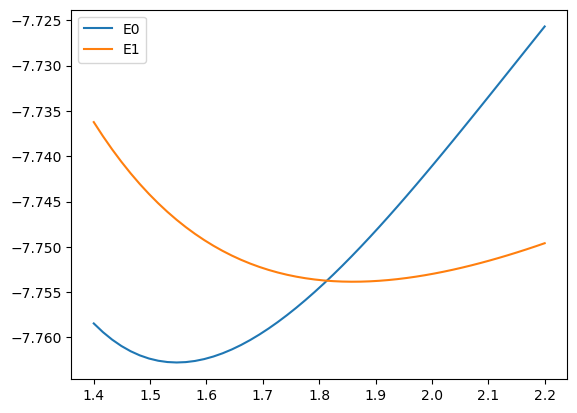

In [12]:
print(r_array)
print(E_array[:,1]-E_array[:,0])

plt.plot(r_array, E_array[:,0]+0.120000, label="E0")
plt.plot(r_array, E_array[:,1], label="E1")
#plt.plot(r_array, E_array[:,2], label="E2")
#plt.plot(r_array, E_array[:,3], label="E3")
plt.legend()
#plt.xlim(1.79, 1.81)
plt.show()

\begin{equation}
\hat{H}_{\alpha n, \beta m} = \left( E_{\alpha}(R) + n \omega \right) \delta_{\alpha \beta} \delta_{nm} - \sqrt{\frac{\omega}{2}} \lambda \cdot \mu_{\alpha \beta}(R) \left(\sqrt{n} \delta_{n,m-1} + \sqrt{n+1} \delta_{n,m+1} \right)  \\
+\frac{1}{2} \sum_{\xi, \xi' \in \{x,y,z\}} \lambda^{\xi} \lambda^{\xi'} {\bf M}^{\xi \xi'}_{\alpha, \beta}(R) \delta_{nm}
\end{equation}

where ${\bf M}$ denotes the $\hat{\mu}^2$ matrix in the CI basis.


In [13]:
def lambda_index_from_composite(k):
    if k==0:
        return 0, 0
    elif k==1:
        return 1, 1
    elif k==2:
        return 2, 2
    elif k==3:
        return 0, 1
    elif k==4:
        return 0, 2
    elif k==5:
        return 1, 2
    
    else:
        print("error")
        return 0, 0

def build_pf_hamiltonian(n_el, n_ph, E_R, omega, lamvec, mu, mumu):
    """
    Given an array of n_el E_R values and an n_ph states with fundamental energy omega
    build the PF Hamiltonian
    
    n_el : int
        the number of electronic states (n_el = 1 means only ground-state)
    
    n_ph : int
        the number of photon occupation states (n_ph = 1 means only the |0> state)
    
    E_R : np.array of floats
        the electronic energies
        
    omega : float
        the energy of the photonic mode
        
    lamvec : np.array of floats
        the lambda vector
        
    mu : (n_el x n_el x 3) np.array of floats 
        mu[i, j, k] is the kth cartesian component of the dipole moment expectation value between 
        state i and state j
        
    mumu : (n_el x n_el x 6) np.array of floats
        mumu[i, j, k] is the kth cartesian component of the dipole squared matrix element 
        between state i and j
        k=0 -> xx, k=1 -> yy, k=2 -> zz, k=3 -> xy, k=4 -> xz, k=5 -> yz
    
    """
    H_PF = np.zeros((n_el * n_ph, n_el * n_ph))
    
    # take care of the diagonals first
    # bare electronic and photonic energy
    for n in range(n_ph):
        for a in range(n_el):
            na = n * n_el + a
            H_PF[na,na] = E_R[a] + n * omega
        

    # dipole self energy
    for n in range(n_ph):
        for a in range(n_el):
            na = n * n_el + a
            for b in range(n_el):
                nb = n * n_el + b
                for k in range(6):
                    xi, xip = lambda_index_from_composite(k)
                    #print(xi, xip, k)
                    H_PF[na, nb] += 0.5 * lamvec[xi] * mumu[a, b, k] * lamvec[xip]
                
                
    # off-diagonal bilinear coupling
    for n in range(n_ph):
        for a in range(n_el):
            na = n * n_el + a
            
            for m in range(n_ph):
                for b in range(n_el):
                    mb = m * n_el + b
                    
                    if n == (m-1) and a != b:
                        #print(n, a, na, m, b, mb)
                        H_PF[na,mb] = -np.sqrt(omega / 2) * np.dot(lamvec, mu[a,b,:]) * np.sqrt(m) 
                        H_PF[mb, na] = -np.sqrt(omega / 2) * np.dot(lamvec, mu[a,b,:]) * np.sqrt(m) 
                        
                    elif n == (m+1) and a != b:
                        #print(n, a, na, m, b, mb)
                        H_PF[na, mb] = -np.sqrt(omega / 2) * np.dot(lamvec, mu[a,b,:]) * np.sqrt(m+1) 
                        H_PF[mb, na] = -np.sqrt(omega / 2) * np.dot(lamvec, mu[a,b,:]) * np.sqrt(m+1)
                        
    
    return H_PF
                
            
    
        
    
    

\begin{equation}
\hat{H}_{\alpha n, \beta m} = \left( E_{\alpha}(R) + n \omega \right) \delta_{\alpha \beta} \delta_{nm} - \sqrt{\frac{\omega}{2}} \lambda \cdot \mu_{\alpha \beta}(R) \left(\sqrt{n} \delta_{n,m-1} + \sqrt{n+1} \delta_{n,m+1} \right)  \\
+\frac{1}{2} \sum_{\xi, \xi' \in \{x,y,z\}} \lambda^{\xi} \lambda^{\xi'} {\bf M}^{\xi \xi'}_{\alpha, \beta}(R) \delta_{nm}
\end{equation}

where ${\bf M}$ denotes the $\hat{\mu}^2$ matrix in the CI basis.


In [14]:
print(np.shape(MuMu_array[0,:,:,:]))

(50, 50, 6)


In [15]:
np.set_printoptions(precision=6, linewidth=200, suppress=True)
omega_cav = 0.12086
lambda_vector = np.array([0, 0.0, 0.08])
N_el = 2
N_ph = 2

_HPF = build_pf_hamiltonian(N_el, N_ph, E_array[0,:], omega_cav, lambda_vector, Mu_array[0, :, :, :], MuMu_array[0, :, :, :])
print("H")
print(_HPF)

H
[[-7.857786 -0.004725  0.       -0.011859]
 [-0.004725 -7.729184 -0.011859  0.      ]
 [ 0.       -0.011859 -7.736926 -0.004725]
 [-0.011859  0.       -0.004725 -7.608324]]


In [16]:
# Just manually computing some elements!
print("E")
print(E_array[0,:2], E_array[0,:2]+0.12, E_array[0,:2]+2*0.12)

#g_12 = np.sqrt(omega_cav / 2) * np.dot(lambda_vector, Mu_array[0, 0, 1, :]) * np.sqrt(2)

D_00 = 0.0
D_01 = 0.0
D_10 = 0.0
for i in range(6):
    xi, xip = lambda_index_from_composite(i)
    print("Mu(1) * Mu(1):", Mu_array[0,0,0,xi] * Mu_array[0, 0, 0, xip])
    print("M:",MuMu_array[0,0,0,i])
    D_00 += 0.5 * lambda_vector[xi] * lambda_vector[xip] * MuMu_array[0, 0, 0, i]
    D_01 += 0.5 * lambda_vector[xi] * lambda_vector[xip] * MuMu_array[0, 0, 1, i]
    D_10 += 0.5 * lambda_vector[xi] * lambda_vector[xip] * MuMu_array[0, 1, 0, i]
    
#D_01 = 0.5 * np.dot(lambda_vector, Mu_array[0, 0, 0, :]) * np.dot(lambda_vector, Mu_array[0, 1, 0, :]) 
#D_01 += 0.5 * np.dot(lambda_vector, Mu_array[0, 0, 1, :]) * np.dot(lambda_vector, Mu_array[0, 1, 1, :])


#print("g12 * 1")
#print(g_12)
print("D00")
print(D_00)
print("D01")
print(D_01)
print("D10")
print(D_10)
print("E0 + D00")
print(E_array[0,0] + D_00)
#+E_array[0,1])

E
[-7.878454 -7.736236] [-7.758454 -7.616236] [-7.638454 -7.496236]
Mu(1) * Mu(1): 4.888817408050046e-33
M: 1.94962710862339
Mu(1) * Mu(1): 2.5922980961234965e-30
M: 1.9496271086233903
Mu(1) * Mu(1): 3.341603737454515
M: 6.458774187459038
Mu(1) * Mu(1): 1.125756281758336e-31
M: -1.9842036369376086e-17
Mu(1) * Mu(1): 1.2781428137134258e-16
M: 1.8845386316102855e-15
Mu(1) * Mu(1): 2.9432011495313227e-15
M: 10.766828303171973
D00
0.020668077399868923
D01
-0.00472507567067409
D10
-0.004725075670674085
E0 + D00
-7.85778557491915


We want to investigate the mean absolute error of a given polariton potential energy surface as a 
function of electronic and photonic truncation:

$$ {\rm MAE} = \frac{1}{N_R} \sum_i^{N_R} \left| E(R_i) - E^{'}(R_i) \right| $$

where $E^{'}(R_i)$ is a value of the polaritonic PES for a truncated level of theory and $E(R_i)$ is the exact value.

In [ ]:
def MAE(E, Ep):
    """
    function to return the mean absolute error of the approximate PES stored in Ep relative to 
    the exact PES stored in E
    """
    # get length
    _NR = len(E)
    
    # take element-by-element difference
    _diff = E - Ep
    
    # compute absolute value of differences
    _absdiff = np.abs(_diff)
    
    # return sum divided by _NR
    return np.sum(_absdiff) / _NR

    

In [ ]:
N_el = 50
N_ph = 50

#PF_EIG = np.zeros((N_R, N_el * N_ph))
#PF_5050 = np.zeros((N_R, N_el * N_ph))
MAE_array = np.zeros((20,20,3))
N_el_array = np.linspace(2, 21, 20, dtype=int)
N_ph_array = np.linspace(2, 21, 20, dtype=int)
print(N_el_array)
print(N_ph_array)

In [17]:

N_el = 20
N_ph = 6 
pf_tmp = np.zeros((N_R, N_el * N_ph ))
for k in range(N_R):           
    _HPF = build_pf_hamiltonian(N_el, N_ph, E_array[k,:], omega_cav, lambda_vector, Mu_array[k, :, :, :], MuMu_array[k, :, :, :])
    pf_e, pf_c = np.linalg.eigh(_HPF)
    pf_tmp[k,:] = pf_e

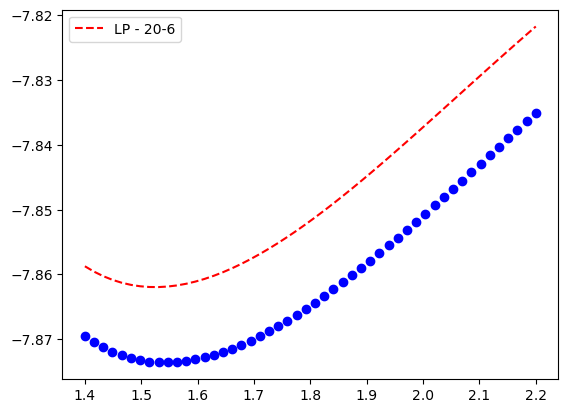

In [22]:

plt.plot(r_array, pf_tmp[:,0], 'r--', label="LP - 20-6")
#plt.plot(r_array, pf_tmp[:,2], 'b--', label="UP - 20-6")
plt.plot(r_array, sc_E_array[:, 0], 'bo')
plt.legend()
plt.show()


